## 1. 环境配置与导入

---
# Part 1: 环境准备与数据加载
---

## 1. 环境准备

In [ ]:
import sys
sys.path.append('..')

import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import re
import torch
from PIL import Image

# TrOCR 相关导入
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# 配置 matplotlib 中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun', 'KaiTi', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 导入自定义模块
from src.custom_ocr import CustomTextRecognizer
from src.custom_ocr.processors import TopKDecoder, CTCDeduplicator, ConfidenceFilter
from src.preprocessing.grid_detection import detect_grid_lines, generate_grid_cells
from src.evaluation import GridAccuracyCalculator

print("✓ 模块导入成功")
print("✓ Matplotlib 中文支持已配置")

## 2. 加载测试数据

In [ ]:
# 项目根目录
project_root = Path('..').resolve()

# 1. 加载图像
img_path = project_root / 'output' / 'temp_cropped.png'
img = cv2.imread(str(img_path))

if img is None:
    raise FileNotFoundError(f"无法加载图像: {img_path}")

print(f"✓ 加载图像: {img.shape}")

# 2. 加载 Ground Truth（读取为字符串）
gt_file = project_root / 'data' / 'samples' / '2022 第2題 (冬奧) (8份)_Original' / 'sample_01_01_ground_truth.txt'
with open(gt_file, 'r', encoding='utf-8') as f:
    ground_truth = f.read()

print(f"✓ 加载 Ground Truth: {len(ground_truth)} 字符")

# 3. 清理 ground truth
gt_clean = re.sub(r'<insert>|</insert>|<\?>', '', ground_truth)
gt_clean = gt_clean.replace('\n', '').replace(' ', '')

print(f"✓ 清理后: {len(gt_clean)} 字符")
print(f"前 50 字符: {gt_clean[:50]}")

## 3. 格子检测与分割

In [ ]:
# 转换为灰度图
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 检测格子线
print("检测格子线...")
lines = detect_grid_lines(gray)
horizontal_lines = lines['horizontal']
vertical_lines = lines['vertical']
print(f"✓ 检测到横线: {len(horizontal_lines)} 条")
print(f"✓ 检测到竖线: {len(vertical_lines)} 条")

# 生成格子
print("\n生成格子网格...")
cells = generate_grid_cells(horizontal_lines, vertical_lines, img.shape[:2])
print(f"✓ 生成格子: {len(cells)} 个")

# 过滤非空格子并裁剪图像
print("\n过滤非空格子并裁剪...")
cell_images = []
non_empty_cells = []

for cell in cells:
    x1, y1, x2, y2 = cell['x1'], cell['y1'], cell['x2'], cell['y2']
    cell_img = img[y1:y2, x1:x2]
    
    # 判断是否为非空格子
    if cell_img.size > 0:
        gray_cell = cv2.cvtColor(cell_img, cv2.COLOR_BGR2GRAY)
        
        # 裁剪中心区域（避免边框干扰）
        h, w = gray_cell.shape
        crop = int(min(h, w) * 0.08)  # 裁剪 8%
        if h > 2*crop and w > 2*crop:
            center_region = gray_cell[crop:h-crop, crop:w-crop]
        else:
            center_region = gray_cell
        
        # 计算中心区域的非白色像素比例
        non_white_ratio = (center_region < 240).sum() / center_region.size
        if non_white_ratio > 0.005:  # 超过0.5%的非白色像素认为是非空
            cell_images.append(cell_img)
            non_empty_cells.append(cell)

print(f"✓ 非空格子数: {len(cell_images)}")
print(f"✓ Ground Truth 字符数: {len(gt_clean)}")

---
# Part 2: PaddleOCR 识别（基线）
---

## 4. PaddleOCR 识别

In [ ]:
# 初始化 PaddleOCR
print("初始化 PaddleOCR...")
print("="*80)

paddle_recognizer = CustomTextRecognizer(
    model_name='PP-OCRv5_server_rec',
    device='gpu:0'
)

print("✓ PaddleOCR 初始化完成")

# 初始化后处理器
decoder = TopKDecoder(k=5)
deduplicator = CTCDeduplicator()
conf_filter = ConfidenceFilter(threshold=0.3)

print("✓ 后处理器初始化完成")

In [ ]:
# 批量识别
print("\nPaddleOCR 批量识别...")
print("="*80)

# 获取原始概率矩阵
batch_raw_outputs = paddle_recognizer.batch_predict_with_raw_output(cell_images)
print(f"✓ 获取 {len(batch_raw_outputs)} 个格子的概率矩阵")

# 方法链式调用后处理
paddle_results = []
for i, raw_output in enumerate(batch_raw_outputs):
    decoded = decoder(raw_output)
    deduped = deduplicator(decoded)
    filtered = conf_filter(deduped)
    paddle_results.append(filtered)
    
    if i < 10:
        print(f"  格子 {i+1:3d}: '{filtered.get('text', ''):8s}' (置信度: {filtered.get('confidence', 0):.3f})")

print(f"\n✓ PaddleOCR 识别完成: {len(paddle_results)} 个非空格子")

In [ ]:
# 辅助函数：恢复空格子
def restore_empty_cells(results_list, cells, non_empty_cells):
    """恢复空格子，构建完整的预测结果"""
    all_cells_dict = {}
    
    # 初始化所有格子为空
    for cell in cells:
        row, col = cell['row'], cell['col']
        all_cells_dict[(row, col)] = {
            'row': row,
            'col': col,
            'text': '',
            'confidence': 1.0,
            'is_empty': True
        }
    
    # 填充非空格子的识别结果
    for result, cell in zip(results_list, non_empty_cells):
        row, col = cell['row'], cell['col']
        all_cells_dict[(row, col)] = {
            'row': row,
            'col': col,
            'text': result.get('text', ''),
            'confidence': result.get('confidence', 0),
            'is_empty': False,
            'ocr_result': result
        }
    
    # 转换为列表（按 row, col 排序）
    prediction_data_full = sorted(all_cells_dict.values(), 
                                  key=lambda x: (x['row'], x['col']))
    
    return prediction_data_full

# 恢复空格子
paddle_prediction_full = restore_empty_cells(paddle_results, cells, non_empty_cells)
print(f"✓ 完整预测结果: {len(paddle_prediction_full)} 个格子")
print(f"  - 非空格子: {len([c for c in paddle_prediction_full if not c['is_empty']])} 个")
print(f"  - 空格子: {len([c for c in paddle_prediction_full if c['is_empty']])} 个")

---
# Part 3: TrOCR 识别
---

## 5. TrOCR 模型加载与识别

In [ ]:
print("="*80)
print("TrOCR 模型加载")
print("="*80)

# 加载 TrOCR 模型
print("\n加载 TrOCR 模型...")
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

# 移动到 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

print(f"✓ 模型加载完成，使用设备: {device}")

In [ ]:
# TrOCR 批量识别
print("\nTrOCR 批量识别...")
print("="*80)

trocr_results = []
with torch.no_grad():
    for i, cell_img in enumerate(cell_images):
        # 转换为 PIL Image (RGB)
        cell_img_rgb = cv2.cvtColor(cell_img, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(cell_img_rgb)
        
        # 预处理
        pixel_values = processor(pil_image, return_tensors="pt").pixel_values.to(device)
        
        # 生成文本（限制为单字符）
        generated_ids = model.generate(
            pixel_values,
            max_length=2,  # 1个起始token + 1个字符
            num_beams=1,
            do_sample=False
        )
        
        # 解码
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        
        # TrOCR 不直接提供置信度，设为固定值
        trocr_results.append({
            'text': generated_text,
            'confidence': 0.5  # 占位值
        })
        
        if i < 10:
            print(f"  格子 {i+1:3d}: '{generated_text:8s}'")
        
        if (i + 1) % 50 == 0:
            print(f"  处理进度: {i+1}/{len(cell_images)}")

print(f"\n✓ TrOCR 识别完成: {len(trocr_results)} 个非空格子")

In [ ]:
# 恢复空格子
trocr_prediction_full = restore_empty_cells(trocr_results, cells, non_empty_cells)
print(f"✓ 完整预测结果: {len(trocr_prediction_full)} 个格子")

---
# Part 4: 准确率评估与对比
---

## 6. 准确率评估

In [ ]:
# 创建计算器实例
calculator = GridAccuracyCalculator(empty_char='')

# 评估 PaddleOCR
print("评估 PaddleOCR...")
print("="*80)
paddle_metrics = calculator.calculate(
    predicted_results=paddle_prediction_full,
    ground_truth=gt_clean,
    align_by_row=True
)

print(f"\nPaddleOCR 准确率:")
print(f"  字符准确率: {paddle_metrics['overall']['accuracy']:.2f}%")
print(f"  正确字符数: {paddle_metrics['overall']['matched_chars']}/{paddle_metrics['overall']['total_chars']}")

# 评估 TrOCR
print("\n评估 TrOCR...")
print("="*80)
trocr_metrics = calculator.calculate(
    predicted_results=trocr_prediction_full,
    ground_truth=gt_clean,
    align_by_row=True
)

print(f"\nTrOCR 准确率:")
print(f"  字符准确率: {trocr_metrics['overall']['accuracy']:.2f}%")
print(f"  正确字符数: {trocr_metrics['overall']['matched_chars']}/{trocr_metrics['overall']['total_chars']}")

## 7. 结果对比

In [ ]:
# 对比结果
print("\n" + "="*80)
print("准确率对比")
print("="*80)

paddle_acc = paddle_metrics['overall']['accuracy']
trocr_acc = trocr_metrics['overall']['accuracy']
improvement = trocr_acc - paddle_acc

paddle_correct = paddle_metrics['overall']['matched_chars']
trocr_correct = trocr_metrics['overall']['matched_chars']
char_improvement = trocr_correct - paddle_correct

print(f"\n{'指标':<20} {'PaddleOCR':>15} {'TrOCR':>15} {'提升':>15}")
print("-"*80)
print(f"{'字符准确率':<20} {paddle_acc:>14.2f}% {trocr_acc:>14.2f}% {improvement:>+14.2f}%")
print(f"{'正确字符数':<20} {paddle_correct:>15} {trocr_correct:>15} {char_improvement:>+15}")
print(f"{'总字符数':<20} {paddle_metrics['overall']['total_chars']:>15} {trocr_metrics['overall']['total_chars']:>15} {0:>15}")

## 8. 识别结果对比示例

In [ ]:
# 重构格子数据以便对比
def reconstruct_cell_data(metrics_dict):
    """从 by_row 结构重构完整的格子列表"""
    cells = []
    for row_result in metrics_dict['by_row']:
        row_idx = row_result['row']
        for col_idx, (pred_text, gt_text, conf) in enumerate(
            zip(row_result['pred_cells'], row_result['gt_cells'], 
                row_result['confidences'])
        ):
            cells.append({
                'row': row_idx,
                'col': col_idx,
                'text': pred_text,
                'confidence': conf,
                'is_empty': (pred_text == '')
            })
    return cells

# 重构格子数据
paddle_cells = reconstruct_cell_data(paddle_metrics)
trocr_cells = reconstruct_cell_data(trocr_metrics)

# 显示对比示例
print("="*100)
print("识别结果对比示例（前 30 个非空格子）")
print("="*100)

print(f"\n{'序号':<6} {'Ground Truth':<15} {'PaddleOCR':<15} {'TrOCR':<15} {'PaddleOCR✓':<12} {'TrOCR✓':<12}")
print("-"*100)

# 只显示非空格子
paddle_non_empty = [c for c in paddle_cells if not c['is_empty']]
trocr_non_empty = [c for c in trocr_cells if not c['is_empty']]

for i in range(min(30, len(paddle_non_empty), len(trocr_non_empty))):
    # 从 gt_clean 获取对应位置的字符
    gt_char = gt_clean[i] if i < len(gt_clean) else ''
    paddle_text = paddle_non_empty[i]['text']
    trocr_text = trocr_non_empty[i]['text']
    
    paddle_correct = '✓' if paddle_text == gt_char else '✗'
    trocr_correct = '✓' if trocr_text == gt_char else '✗'
    
    print(f"{i+1:<6} {gt_char:<15} {paddle_text:<15} {trocr_text:<15} {paddle_correct:<12} {trocr_correct:<12}")

## 9. 错误案例分析

In [ ]:
# 错误案例分析
print("="*100)
print("错误案例分析")
print("="*100)

paddle_non_empty = [c for c in paddle_cells if not c['is_empty']]
trocr_non_empty = [c for c in trocr_cells if not c['is_empty']]

both_correct = []
both_wrong = []
paddle_only = []  # 只有 PaddleOCR 正确
trocr_only = []   # 只有 TrOCR 正确

for i in range(min(len(paddle_non_empty), len(trocr_non_empty), len(gt_clean))):
    gt_char = gt_clean[i]
    paddle_text = paddle_non_empty[i]['text']
    trocr_text = trocr_non_empty[i]['text']
    
    paddle_correct = (paddle_text == gt_char)
    trocr_correct = (trocr_text == gt_char)
    
    if paddle_correct and trocr_correct:
        both_correct.append(i)
    elif not paddle_correct and not trocr_correct:
        both_wrong.append((i, gt_char, paddle_text, trocr_text))
    elif paddle_correct and not trocr_correct:
        paddle_only.append((i, gt_char, paddle_text, trocr_text))
    else:  # trocr_correct and not paddle_correct
        trocr_only.append((i, gt_char, paddle_text, trocr_text))

print(f"\n✓ 两者都正确: {len(both_correct)} 个")
print(f"✗ 两者都错误: {len(both_wrong)} 个")
print(f"⚡ 仅 PaddleOCR 正确: {len(paddle_only)} 个")
print(f"⚡ 仅 TrOCR 正确: {len(trocr_only)} 个")

# 显示 TrOCR 优势案例
if trocr_only:
    print(f"\n\n{'='*100}")
    print("TrOCR 优势案例（TrOCR 正确，PaddleOCR 错误）")
    print("="*100)
    print(f"\n{'序号':<6} {'Ground Truth':<15} {'PaddleOCR':<15} {'TrOCR':<15}")
    print("-"*100)
    for idx, gt_char, paddle_text, trocr_text in trocr_only[:10]:
        print(f"{idx+1:<6} {gt_char:<15} {paddle_text:<15} {trocr_text:<15}")

# 显示 PaddleOCR 优势案例
if paddle_only:
    print(f"\n\n{'='*100}")
    print("PaddleOCR 优势案例（PaddleOCR 正确，TrOCR 错误）")
    print("="*100)
    print(f"\n{'序号':<6} {'Ground Truth':<15} {'PaddleOCR':<15} {'TrOCR':<15}")
    print("-"*100)
    for idx, gt_char, paddle_text, trocr_text in paddle_only[:10]:
        print(f"{idx+1:<6} {gt_char:<15} {paddle_text:<15} {trocr_text:<15}")

# 显示两者都错误的案例
if both_wrong:
    print(f"\n\n{'='*100}")
    print("两者都错误的案例")
    print("="*100)
    print(f"\n{'序号':<6} {'Ground Truth':<15} {'PaddleOCR':<15} {'TrOCR':<15}")
    print("-"*100)
    for idx, gt_char, paddle_text, trocr_text in both_wrong[:10]:
        print(f"{idx+1:<6} {gt_char:<15} {paddle_text:<15} {trocr_text:<15}")

## 10. 结论与建议

In [ ]:
print("="*100)
print("实验结论")
print("="*100)

improvement = trocr_acc - paddle_acc

print(f"\n1. 字符准确率提升: {improvement:+.2f}%")
print(f"2. 字符改进数: {char_improvement:+d} 个")
print(f"3. TrOCR 独有优势: {len(trocr_only)} 个格子")
print(f"4. PaddleOCR 独有优势: {len(paddle_only)} 个格子")
print(f"5. 净优势: {len(trocr_only) - len(paddle_only):+d} 个格子")

print("\n" + "="*100)
if improvement > 3:
    print("✅ 建议：TrOCR 效果显著提升，值得投入时间开发 Top-K 支持")
    print("   - 建议下一步：开发 TrOCR 的 Top-K 候选输出功能")
    print("   - 预期收益：进一步结合 BERT 上下文增强")
elif improvement > 1:
    print("⚠️ 建议：TrOCR 有轻微提升，可以考虑但需权衡开发成本")
    print("   - 建议下一步：分析错误案例，评估提升潜力")
    print("   - 权衡因素：开发时间 vs 1-3% 准确率提升")
else:
    print("❌ 建议：TrOCR 提升不明显，不建议替换 PaddleOCR")
    print("   - 原因：TrOCR 主要训练英文手写，中文效果有限")
    print("   - 建议：继续优化 PaddleOCR + BERT 组合")

print("\n注意事项：")
print("1. TrOCR 主要训练英文手写，中文效果可能需要微调")
print("2. 当前测试未使用 Top-K，实际集成需要额外开发")
print("3. TrOCR 推理速度较 PaddleOCR 慢，需考虑效率")
print("4. 如需继续研究 TrOCR，建议尝试：")
print("   - 使用中文预训练的 TrOCR 模型")
print("   - 在手写中文数据集上微调")
print("   - 提取 logits 实现 Top-K 候选输出")
print("="*100)

In [7]:
import sys
sys.path.append('..')

import numpy as np
import cv2
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# 项目根目录
project_root = Path('..').resolve()
# 配置 matplotlib 中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun', 'KaiTi', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 导入自定义模块
from src.custom_ocr import CustomTextRecognizer
from src.preprocessing.grid_detection import detect_grid_lines, generate_grid_cells
from src.evaluation import GridAccuracyCalculator


print(f"✓ 项目根目录: {project_root}")
print("✓ 模块导入成功")
print("✓ Matplotlib 中文支持已配置")
print(f"✓ PyTorch 版本: {torch.__version__}")
print(f"✓ CUDA 可用: {torch.cuda.is_available()}")

✓ 项目根目录: C:\Users\Quenton\Documents\Github\writtingOCR
✓ 模块导入成功
✓ Matplotlib 中文支持已配置
✓ PyTorch 版本: 2.9.1+cu126
✓ CUDA 可用: True


## 2. 加载数据

✓ 图像尺寸: (2900, 2170, 3)
✓ Ground Truth 文件: sample_01_01_ground_truth.txt


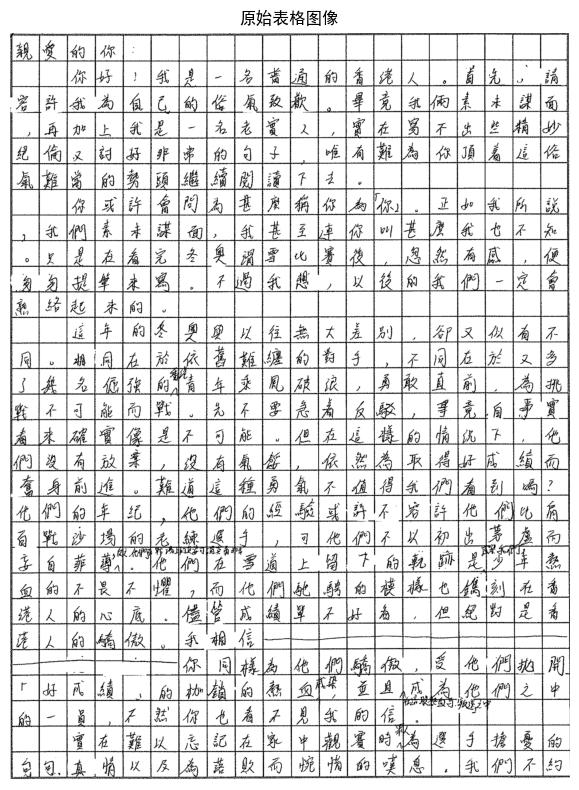

In [8]:
# 数据路径
image_path = project_root / 'output' / 'temp_cropped.png'
gt_file = project_root / 'data' / 'samples' / '2022 第2題 (冬奧) (8份)_Original' / 'sample_01_01_ground_truth.txt'

# 加载图像
image = cv2.imread(str(image_path))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(f"✓ 图像尺寸: {image.shape}")
print(f"✓ Ground Truth 文件: {gt_file.name}")

# 显示图像
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.title('原始表格图像')
plt.axis('off')
plt.tight_layout()
plt.show()

## 3. 加载 Ground Truth

In [9]:
def load_ground_truth(gt_file):
    """加载 Ground Truth 数据"""
    ground_truth = []
    with open(gt_file, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split('\t')
            if len(parts) >= 9:
                ground_truth.append({
                    'coords': list(map(int, parts[:8])),
                    'text': parts[8]
                })
    return ground_truth

ground_truth = load_ground_truth(gt_file)
print(f"✓ 加载了 {len(ground_truth)} 个格子的标注")
print(f"\n前3个示例:")
for i, gt in enumerate(ground_truth[:3]):
    print(f"  格子 {i+1}: '{gt['text']}'")

✓ 加载了 0 个格子的标注

前3个示例:


## 4. 表格检测与格子提取

In [5]:
# 检测表格线
grid_data = detect_grid_lines(
    image,
    vertical_kernel_width=6,
    horizontal_kernel_height=3,
    min_line_length=50,
    canny_threshold1=50,
    canny_threshold2=150
)

print(f"✓ 检测到 {len(grid_data['vertical_lines'])} 条垂直线")
print(f"✓ 检测到 {len(grid_data['horizontal_lines'])} 条水平线")

# 生成格子
cells = generate_grid_cells(
    grid_data,
    image.shape,
    margin=5
)

print(f"✓ 生成了 {len(cells)} 个格子")

TypeError: detect_grid_lines() got an unexpected keyword argument 'vertical_kernel_width'

## 5. PaddleOCR 识别（基线）

In [ ]:
print("="*80)
print("PaddleOCR 识别")
print("="*80)

# 初始化 PaddleOCR
paddle_recognizer = CustomTextRecognizer(
    model_name='PP-OCRv5_server_rec',
    device='gpu:0'
)

# 识别所有格子
paddle_results = []
for i, cell in enumerate(cells):
    y1, y2, x1, x2 = cell['y1'], cell['y2'], cell['x1'], cell['x2']
    cell_img = image[y1:y2, x1:x2]
    
    result = paddle_recognizer.recognize(cell_img)
    paddle_results.append({
        'text': result['text'],
        'confidence': result['confidence'],
        'cell_index': i
    })
    
    if (i + 1) % 50 == 0:
        print(f"  处理进度: {i+1}/{len(cells)}")

print(f"\n✓ PaddleOCR 识别完成: {len(paddle_results)} 个格子")

## 6. TrOCR 识别

In [ ]:
print("="*80)
print("TrOCR 识别")
print("="*80)

# 加载 TrOCR 模型
print("\n加载 TrOCR 模型...")
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

# 移动到 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

print(f"✓ 模型加载完成，使用设备: {device}")

# 识别所有格子
trocr_results = []
with torch.no_grad():
    for i, cell in enumerate(cells):
        y1, y2, x1, x2 = cell['y1'], cell['y2'], cell['x1'], cell['x2']
        cell_img = image[y1:y2, x1:x2]
        
        # 转换为 PIL Image
        cell_img_rgb = cv2.cvtColor(cell_img, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(cell_img_rgb)
        
        # 预处理
        pixel_values = processor(pil_image, return_tensors="pt").pixel_values.to(device)
        
        # 生成文本（限制为单字符）
        generated_ids = model.generate(
            pixel_values,
            max_length=2,  # 限制长度（1个token起始 + 1个字符）
            num_beams=1,
            do_sample=False
        )
        
        # 解码
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        
        # TrOCR 不直接提供置信度，暂时设为 0.5
        trocr_results.append({
            'text': generated_text,
            'confidence': 0.5,  # 占位值
            'cell_index': i
        })
        
        if (i + 1) % 50 == 0:
            print(f"  处理进度: {i+1}/{len(cells)}")

print(f"\n✓ TrOCR 识别完成: {len(trocr_results)} 个格子")

## 7. 准确率评估

In [ ]:
def calculate_accuracy(results, ground_truth):
    """计算识别准确率"""
    total_chars = 0
    correct_chars = 0
    correct_cells = 0
    
    for result, gt in zip(results, ground_truth):
        pred_text = result['text']
        true_text = gt['text']
        
        # 格子准确率
        if pred_text == true_text:
            correct_cells += 1
        
        # 字符准确率
        total_chars += len(true_text)
        for p, t in zip(pred_text, true_text):
            if p == t:
                correct_chars += 1
    
    char_accuracy = (correct_chars / total_chars * 100) if total_chars > 0 else 0
    cell_accuracy = (correct_cells / len(results) * 100) if len(results) > 0 else 0
    
    return {
        'char_accuracy': char_accuracy,
        'cell_accuracy': cell_accuracy,
        'correct_chars': correct_chars,
        'total_chars': total_chars,
        'correct_cells': correct_cells,
        'total_cells': len(results)
    }

# 评估 PaddleOCR
paddle_acc = calculate_accuracy(paddle_results, ground_truth)

# 评估 TrOCR
trocr_acc = calculate_accuracy(trocr_results, ground_truth)

# 输出结果
print("="*80)
print("准确率对比")
print("="*80)

print(f"\n{'指标':<20} {'PaddleOCR':>15} {'TrOCR':>15} {'提升':>15}")
print("-"*80)
print(f"{'字符准确率':<20} {paddle_acc['char_accuracy']:>14.2f}% {trocr_acc['char_accuracy']:>14.2f}% {trocr_acc['char_accuracy']-paddle_acc['char_accuracy']:>+14.2f}%")
print(f"{'格子准确率':<20} {paddle_acc['cell_accuracy']:>14.2f}% {trocr_acc['cell_accuracy']:>14.2f}% {trocr_acc['cell_accuracy']-paddle_acc['cell_accuracy']:>+14.2f}%")
print(f"{'正确字符数':<20} {paddle_acc['correct_chars']:>15} {trocr_acc['correct_chars']:>15} {trocr_acc['correct_chars']-paddle_acc['correct_chars']:>+15}")
print(f"{'正确格子数':<20} {paddle_acc['correct_cells']:>15} {trocr_acc['correct_cells']:>15} {trocr_acc['correct_cells']-paddle_acc['correct_cells']:>+15}")

## 8. 识别结果对比示例

In [ ]:
def display_comparison(num_samples=20):
    """显示识别结果对比"""
    print("="*100)
    print("识别结果对比示例")
    print("="*100)
    print(f"\n{'序号':<6} {'Ground Truth':<15} {'PaddleOCR':<15} {'TrOCR':<15} {'PaddleOCR✓':<12} {'TrOCR✓':<12}")
    print("-"*100)
    
    for i in range(min(num_samples, len(ground_truth))):
        gt_text = ground_truth[i]['text']
        paddle_text = paddle_results[i]['text']
        trocr_text = trocr_results[i]['text']
        
        paddle_correct = '✓' if paddle_text == gt_text else '✗'
        trocr_correct = '✓' if trocr_text == gt_text else '✗'
        
        print(f"{i+1:<6} {gt_text:<15} {paddle_text:<15} {trocr_text:<15} {paddle_correct:<12} {trocr_correct:<12}")

display_comparison(30)

## 9. 错误案例分析

In [ ]:
def analyze_errors():
    """分析错误案例"""
    paddle_errors = []
    trocr_errors = []
    both_correct = []
    both_wrong = []
    paddle_only = []  # 只有 PaddleOCR 正确
    trocr_only = []   # 只有 TrOCR 正确
    
    for i, (gt, paddle, trocr) in enumerate(zip(ground_truth, paddle_results, trocr_results)):
        gt_text = gt['text']
        paddle_text = paddle['text']
        trocr_text = trocr['text']
        
        paddle_correct = (paddle_text == gt_text)
        trocr_correct = (trocr_text == gt_text)
        
        if paddle_correct and trocr_correct:
            both_correct.append(i)
        elif not paddle_correct and not trocr_correct:
            both_wrong.append((i, gt_text, paddle_text, trocr_text))
        elif paddle_correct and not trocr_correct:
            paddle_only.append((i, gt_text, paddle_text, trocr_text))
        else:  # trocr_correct and not paddle_correct
            trocr_only.append((i, gt_text, paddle_text, trocr_text))
    
    print("="*100)
    print("错误案例分析")
    print("="*100)
    print(f"\n✓ 两者都正确: {len(both_correct)} 个")
    print(f"✗ 两者都错误: {len(both_wrong)} 个")
    print(f"⚡ 仅 PaddleOCR 正确: {len(paddle_only)} 个")
    print(f"⚡ 仅 TrOCR 正确: {len(trocr_only)} 个")
    
    # 显示仅 TrOCR 正确的案例（TrOCR 的优势）
    if trocr_only:
        print(f"\n\n{'='*100}")
        print("TrOCR 优势案例（TrOCR 正确，PaddleOCR 错误）")
        print("="*100)
        print(f"\n{'序号':<6} {'Ground Truth':<15} {'PaddleOCR':<15} {'TrOCR':<15}")
        print("-"*100)
        for idx, gt_text, paddle_text, trocr_text in trocr_only[:10]:
            print(f"{idx+1:<6} {gt_text:<15} {paddle_text:<15} {trocr_text:<15}")
    
    # 显示仅 PaddleOCR 正确的案例（PaddleOCR 的优势）
    if paddle_only:
        print(f"\n\n{'='*100}")
        print("PaddleOCR 优势案例（PaddleOCR 正确，TrOCR 错误）")
        print("="*100)
        print(f"\n{'序号':<6} {'Ground Truth':<15} {'PaddleOCR':<15} {'TrOCR':<15}")
        print("-"*100)
        for idx, gt_text, paddle_text, trocr_text in paddle_only[:10]:
            print(f"{idx+1:<6} {gt_text:<15} {paddle_text:<15} {trocr_text:<15}")

analyze_errors()

## 10. 结论与建议

In [ ]:
print("="*100)
print("实验结论")
print("="*100)

char_diff = trocr_acc['char_accuracy'] - paddle_acc['char_accuracy']
cell_diff = trocr_acc['cell_accuracy'] - paddle_acc['cell_accuracy']

print(f"\n1. 字符准确率提升: {char_diff:+.2f}%")
print(f"2. 格子准确率提升: {cell_diff:+.2f}%")

if char_diff > 3:
    print("\n✅ 建议：TrOCR 效果显著提升，值得投入时间开发 Top-K 支持")
elif char_diff > 1:
    print("\n⚠️ 建议：TrOCR 有轻微提升，可以考虑但需权衡开发成本")
else:
    print("\n❌ 建议：TrOCR 提升不明显，不建议替换 PaddleOCR")

print("\n注意事项：")
print("1. TrOCR 主要训练英文手写，中文效果可能需要微调")
print("2. 当前测试未使用 Top-K，实际集成需要额外开发")
print("3. TrOCR 速度较慢，需要考虑推理效率")